In [1]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import matplotlib.pyplot as plt
import os.path

In [2]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['London_Loop_Train',
 'H_track',
 'canada_race',
 'Straight_track',
 'AWS_track',
 'reinvent_base',
 'China_track',
 'reInvent2019_track',
 '2022_july_open',
 'Bowtie_track',
 '2022_june_open',
 'Oval_track',
 'Virtual_May19_Train_track',
 'Tokyo_Training_track',
 'Mexico_track',
 'Canada_Training',
 'New_York_Track']

In [3]:
# Replace the name here with the track to analyze
TRACK_NAME = '2022_july_open'

# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Separate into center, inner, outer waypoints
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

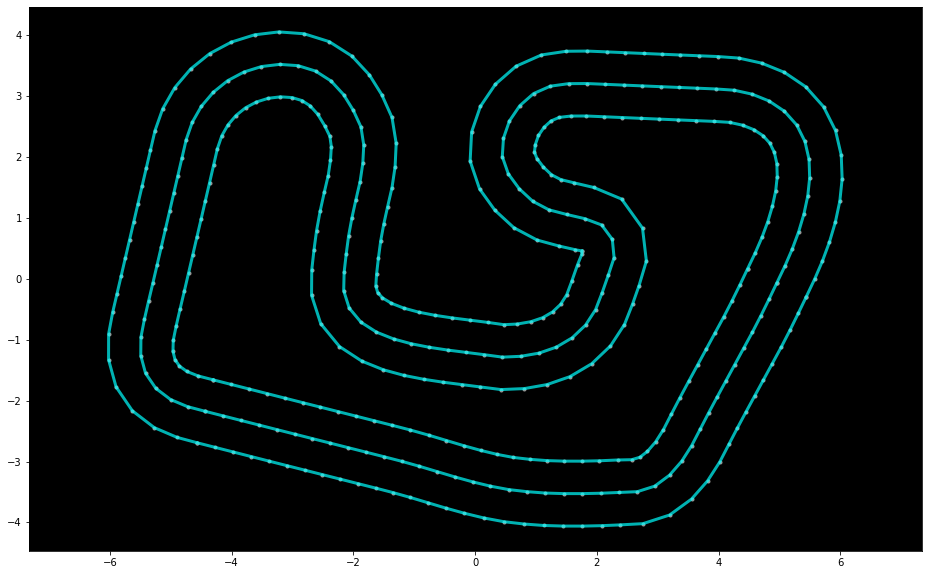

In [4]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

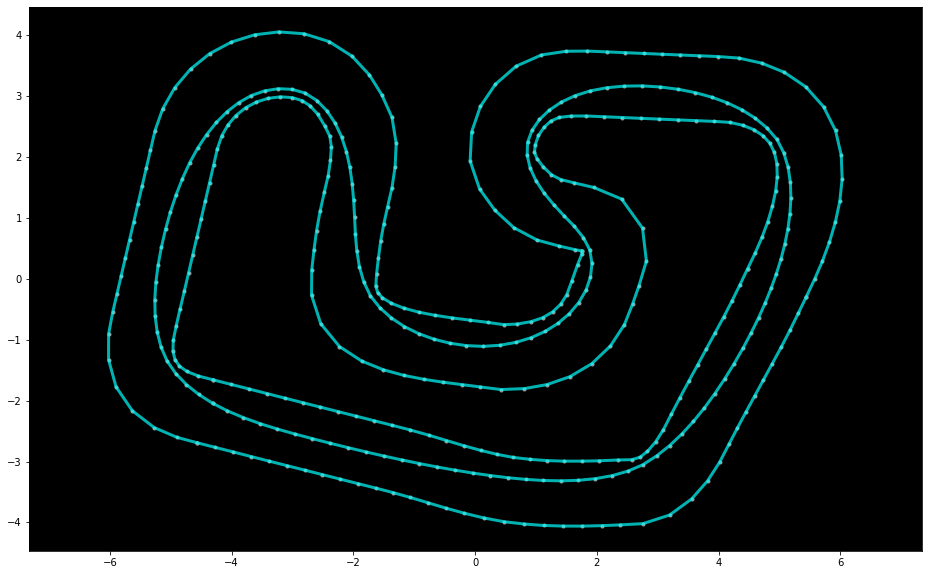

In [5]:
from numpy import array

fname = './racelines/2022_july_open-2000-4-2022-08-22-145947.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, racing_line, inner_border, outer_border)

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [7]:
npoints = len(racing_line) - 1

In [8]:
from numpy import array

fname = './speeds/2022_july_open-0-5-2022-08-22-150713.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
final_optimal_speeds = deserialized

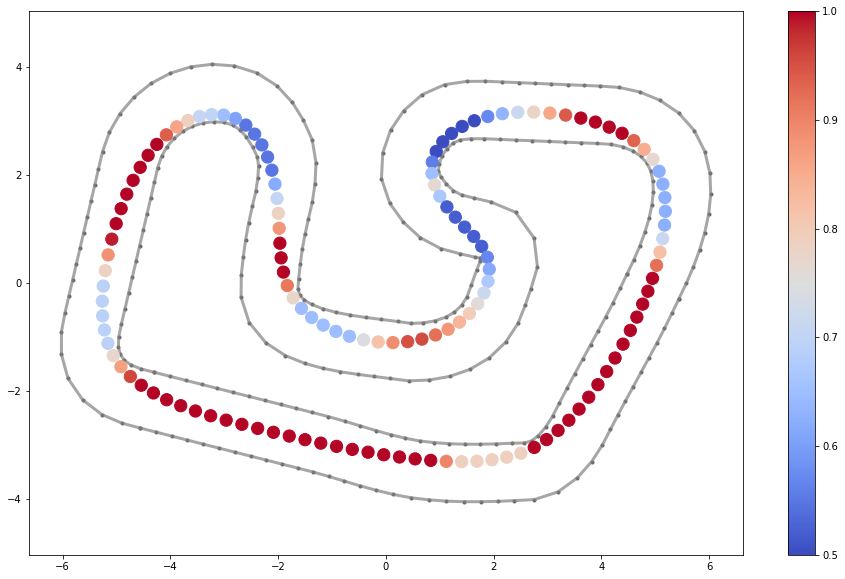

In [9]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    racing_line[:npoints, 0], racing_line[:npoints, 1], s=150,
    c=final_optimal_speeds, cmap='coolwarm', zorder=3
)
fig.colorbar(scatter)

In [10]:
MAX_SPEED = 1.0
MIN_SPEED = 0.5

speed_diff = np.diff(final_optimal_speeds, prepend=final_optimal_speeds[0])
turn_points = np.zeros_like(speed_diff)
turn_points[speed_diff <= 0] = 1
turn_points[final_optimal_speeds == MAX_SPEED] = 0
turn_points[final_optimal_speeds == MIN_SPEED] = 1

In [11]:
for i in range(npoints):
    prv_point = (i - 1) % npoints
    prv_prv_point = (i - 2) % npoints
    nxt_point = (i + 1) % npoints
    nxt_nxt_point = (i + 2) % npoints
    if final_optimal_speeds[i] > final_optimal_speeds[prv_point] and final_optimal_speeds[prv_point] <= final_optimal_speeds[prv_prv_point]:
        turn_points[i] = 1
        turn_points[nxt_point] = 1
        turn_points[nxt_nxt_point] = 1

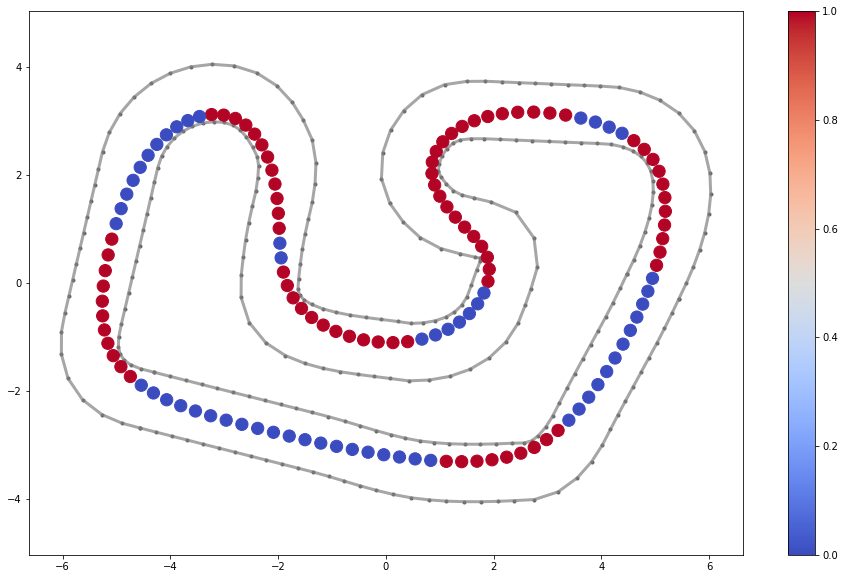

In [12]:
fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    racing_line[:npoints, 0], racing_line[:npoints, 1], s=150,
    c=turn_points, cmap='coolwarm', zorder=3
)
fig.colorbar(scatter)

In [13]:
from datetime import datetime

now = datetime.now()
prefix = './turn-points/%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(turn_points))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, turn_points)

Writing python code to ./turn-points/2022_july_open-2022-08-22-151546.py
Writing numpy binary to ./turn-points/2022_july_open-2022-08-22-151546.npy


In [14]:
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

In [15]:
turn_curvatures = np.zeros_like(turn_points)
start_turn_id = None
min_curvature = 1000
for i in range(npoints):
    prv = (i - 1) % npoints
    nxt = (i + 1) % npoints
    if turn_points[i] and not turn_points[prv]:
        start_turn_id = i
    elif not turn_points[i] and turn_points[prv]:
        turn_curvatures[start_turn_id:i] = min_curvature
        start_turn_id = None
        min_curvature = 1000
    if start_turn_id is not None:
        points = [[racing_line[prv, 0], racing_line[prv, 1]], [racing_line[i, 0], racing_line[i, 1]], [racing_line[nxt, 0], racing_line[nxt, 1]]]
        min_curvature = min(min_curvature, circle_radius(points))
turn_curvatures

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.64015379,
       1.64015379, 1.64015379, 1.64015379, 1.64015379, 1.64015379,
       1.64015379, 1.64015379, 1.64015379, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.02734261, 1.02734261, 1.02734261, 1.02734261, 1.02734261,
       1.02734261, 1.02734261, 1.02734261, 1.02734261, 1.02734261,
       1.02734261, 0.        , 0.        , 0.        , 0.        ,
       0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 ,
       0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 ,
       0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 ,
       0.6588329 , 0.6588329 , 0.6588329 , 0.6588329 , 0.65883

In [16]:
from datetime import datetime

now = datetime.now()
prefix = './turn-curvatures/%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(turn_curvatures))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, turn_curvatures)

Writing python code to ./turn-curvatures/2022_july_open-2022-08-22-151620.py
Writing numpy binary to ./turn-curvatures/2022_july_open-2022-08-22-151620.npy


In [17]:
average_straight_speeds = np.zeros_like(turn_points)
start_straight_id = None
speed_sum = 0
for i in range(npoints):
    prv = (i - 1) % npoints
    nxt = (i + 1) % npoints
    if (not turn_points[i] and turn_points[prv]) or i == 0:
        start_straight_id = i
    if start_straight_id is not None:
        speed_sum += final_optimal_speeds[i]
    if (turn_points[nxt] and not turn_points[i]) or i == (npoints - 1):
        average_straight_speeds[start_straight_id:(i + 1)] = speed_sum / (i - start_straight_id + 1)
        start_straight_id = None
        speed_sum = 0
average_straight_speeds

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [18]:
print(np.amin(average_straight_speeds[average_straight_speeds != 0]))
print(np.amax(average_straight_speeds))

0.8373540171428571
1.0


In [19]:
from datetime import datetime

now = datetime.now()
prefix = './straight-avg-speeds/%s-%s' % (TRACK_NAME, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(average_straight_speeds))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, average_straight_speeds)

Writing python code to ./straight-avg-speeds/2022_july_open-2022-08-22-151657.py
Writing numpy binary to ./straight-avg-speeds/2022_july_open-2022-08-22-151657.npy


In [20]:
print(racing_line[1])

[-4.06795844 -2.16668643]
